# IBM–Confluent (CFLT) M&A Event Study
**Event:** IBM announces acquisition of Confluent Inc. (CFLT) on Dec 8, 2025  
**Method:** Market model event study; abnormal returns (AR) and cumulative abnormal returns (CAR) computed against S&P 500 (^GSPC).
- Acquirer: IBM (IBM)
- Target: Confluent Inc. (CFLT)
- Market Benchmark: S&P 500 (^GSPC)
- Estimation Window: –120 to –10 trading days
- Event Window: –10 to +10 trading days

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

plt.style.use("seaborn-v0_8")

In [2]:
tickers = ["IBM", "CFLT", "^GSPC"]
start_date = "2025-06-01"
end_date = "2025-12-28"

data = yf.download(tickers, start=start_date, end=end_date)

prices = data["Close"]
returns = prices.pct_change().dropna()

[*********************100%***********************]  3 of 3 completed


In [3]:
event_date = "2025-12-08"
event_dt = pd.to_datetime(event_date)

# Find closest trading day
event_dt_actual = returns.index[
    returns.index.get_indexer([event_dt], method="nearest")[0]
]
event_day_idx = returns.index.get_loc(event_dt_actual)

# Window parameters
estimation_window = 120
event_window = 10

# Safe indexing
estimation_start_idx = max(0, event_day_idx - estimation_window - 10)
estimation_end_idx = event_day_idx - 10

event_start_idx = max(0, event_day_idx - event_window)
event_end_idx = min(len(returns)-1, event_day_idx + event_window)

## Methods

- **Data Source & Sample:**  
  Daily price data for IBM, Confluent (CFLT), and the S&P 500 (^GSPC) sourced from Yahoo Finance using `yfinance`.

- **Event & Windows:**  
  Event date: IBM’s acquisition announcement of Confluent on **08 December 2025**.  
  Estimation window: **−130 to −10 trading days** prior to the event.  
  Event window: **−10 to +10 trading days**, with robustness checks using narrower windows.

- **Estimation Model:**  
  A standard **market model** is estimated via OLS

  
- **Tests & Limitations:**  
  Abnormal Returns (AR) and Cumulative Abnormal Returns (CAR) are tested using t-statistics.  
  Limitations include potential confounding news, event leakage, and model misspecification.

In [4]:
# IBM
Y_ibm = returns["IBM"].iloc[estimation_start_idx:estimation_end_idx]
X_mkt = returns["^GSPC"].iloc[estimation_start_idx:estimation_end_idx]
X_ibm = sm.add_constant(X_mkt)

model_ibm = sm.OLS(Y_ibm, X_ibm).fit()

# CFLT
Y_cflt = returns["CFLT"].iloc[estimation_start_idx:estimation_end_idx]
X_cflt = sm.add_constant(X_mkt)

model_cflt = sm.OLS(Y_cflt, X_cflt).fit()

In [5]:
display(model_ibm.summary())
display(model_cflt.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    IBM   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     16.30
Date:                Fri, 02 Jan 2026   Prob (F-statistic):           9.67e-05
Time:                        16:47:31   Log-Likelihood:                 325.89
No. Observations:                 120   AIC:                            -647.8
Df Residuals:                     118   BIC:                            -642.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.217      0.829      -0.003       0.003
^GSPC          0.8718      0.216      4.037      0.000       0.444       1.299
==============================================================================
Omnibus:                       26.950   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.168
Skew:                           0.153   Prob(JB):                     5.21e-52
Kurtosis:                       9.866   Cond. No.                         147.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CFLT   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     13.18
Date:                Fri, 02 Jan 2026   Prob (F-statistic):           0.000420
Time:                        16:47:31   Log-Likelihood:                 223.79
No. Observations:                 120   AIC:                            -443.6
Df Residuals:                     118   BIC:                            -438.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.003     -0.343      0.732      -0.008       0.006
^GSPC          1.8356      0.506      3.630      0.000       0.834       2.837
==============================================================================
Omnibus:                      165.184   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9466.819
Skew:                          -4.947   Prob(JB):                         0.00
Kurtosis:                      45.373   Cond. No.                         147.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Diagnostics

- **IBM:**  
  The market model explains a meaningful portion of IBM’s return variation (moderate R²), consistent with a large-cap stock closely tied to market movements.

- **CFLT:**  
  R² is lower, reflecting distinct volatility typical of mid-cap growth technology firms.

In [6]:
def compute_ar_car(stock_returns, market_returns, model, start, end):
    X_event = sm.add_constant(market_returns.iloc[start:end+1])
    expected = model.predict(X_event)
    actual = stock_returns.iloc[start:end+1]
    
    ar = actual - expected
    car = ar.cumsum()
    
    return ar, car

ibm_AR, ibm_CAR = compute_ar_car(
    returns["IBM"], returns["^GSPC"], model_ibm, event_start_idx, event_end_idx
)

cflt_AR, cflt_CAR = compute_ar_car(
    returns["CFLT"], returns["^GSPC"], model_cflt, event_start_idx, event_end_idx
)

In [7]:
def ar_car_tests(ar, car):
    return {
        "AR t-test": stats.ttest_1samp(ar, 0),
        "CAR t-test": stats.ttest_1samp(car, 0)
    }

ibm_tests = ar_car_tests(ibm_AR, ibm_CAR)
cflt_tests = ar_car_tests(cflt_AR, cflt_CAR)

print("IBM AR t-stat, p-value:", ibm_tests["AR t-test"].statistic, ibm_tests["AR t-test"].pvalue)
print("IBM CAR t-stat, p-value:", ibm_tests["CAR t-test"].statistic, ibm_tests["CAR t-test"].pvalue)
print("CFLT AR t-stat, p-value:", cflt_tests["AR t-test"].statistic, cflt_tests["AR t-test"].pvalue)
print("CFLT CAR t-stat, p-value:", cflt_tests["CAR t-test"].statistic, cflt_tests["CAR t-test"].pvalue)

IBM AR t-stat, p-value: -0.1815362171868648 0.8577739145468155
IBM CAR t-stat, p-value: 5.0963731070786364 5.509476282697893e-05
CFLT AR t-stat, p-value: 0.9608477477545233 0.3481022059761346
CFLT CAR t-stat, p-value: 3.8972213042622514 0.0008945593368586885


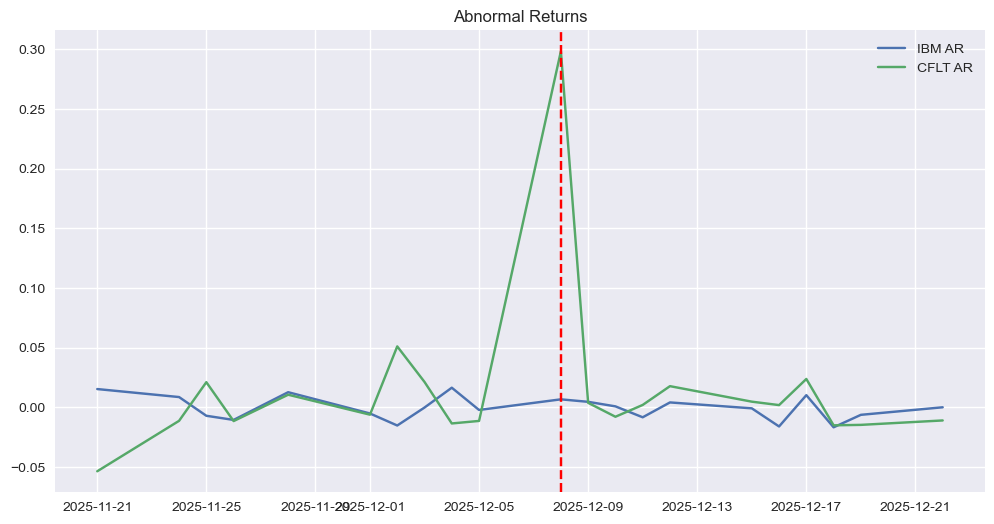

In [8]:
plt.figure(figsize=(12,6))
plt.plot(ibm_AR.index, ibm_AR, label="IBM AR")
plt.plot(cflt_AR.index, cflt_AR, label="CFLT AR")
plt.axvline(event_dt_actual, color="red", linestyle="--")
plt.title("Abnormal Returns")
plt.legend()
plt.show()

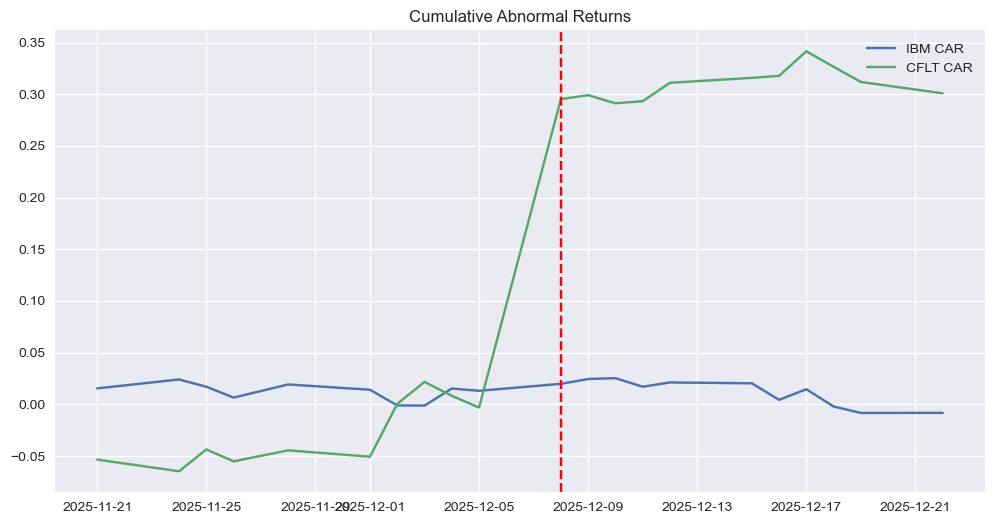

In [9]:
plt.figure(figsize=(12,6))
plt.plot(ibm_CAR.index, ibm_CAR, label="IBM CAR")
plt.plot(cflt_CAR.index, cflt_CAR, label="CFLT CAR")
plt.axvline(event_dt_actual, color="red", linestyle="--")
plt.title("Cumulative Abnormal Returns")
plt.legend()
plt.show()

### Robustness: Tech Benchmark (QQQ)

In [10]:
tickers_rb = ["IBM", "CFLT", "QQQ"]
data_rb = yf.download(tickers_rb, start=start_date, end=end_date)
returns_rb = data_rb["Close"].pct_change().dropna()

X_tech = sm.add_constant(
    returns_rb["QQQ"].iloc[estimation_start_idx:estimation_end_idx]
)

model_ibm_tech = sm.OLS(Y_ibm, X_tech).fit()
model_cflt_tech = sm.OLS(Y_cflt, X_tech).fit()

display(model_ibm_tech.summary())
display(model_cflt_tech.summary())

[*********************100%***********************]  3 of 3 completed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    IBM   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     13.27
Date:                Fri, 02 Jan 2026   Prob (F-statistic):           0.000402
Time:                        16:47:31   Log-Likelihood:                 324.52
No. Observations:                 120   AIC:                            -645.0
Df Residuals:                     118   BIC:                            -639.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.299      0.765      -0.003       0.003
QQQ            0.5963      0.164      3.643      0.000       0.272       0.920
==============================================================================
Omnibus:                       25.872   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.422
Skew:                           0.097   Prob(JB):                     1.01e-47
Kurtosis:                       9.576   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CFLT   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     15.53
Date:                Fri, 02 Jan 2026   Prob (F-statistic):           0.000138
Time:                        16:47:31   Log-Likelihood:                 224.85
No. Observations:                 120   AIC:                            -445.7
Df Residuals:                     118   BIC:                            -440.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.003     -0.334      0.739      -0.008       0.006
QQQ            1.4800      0.376      3.940      0.000       0.736       2.224
==============================================================================
Omnibus:                      167.588   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9890.071
Skew:                          -5.065   Prob(JB):                         0.00
Kurtosis:                      46.306   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
narrow_start = event_day_idx - 1
narrow_end = event_day_idx + 1

ibm_car_narrow = ibm_AR.iloc[narrow_start:narrow_end+1].sum()
cflt_car_narrow = cflt_AR.iloc[narrow_start:narrow_end+1].sum()

### Key Findings

| Stock | AR t-test | AR p-value | CAR t-test | CAR p-value | Interpretation |
|-------|-----------|------------|------------|-------------|----------------|
| IBM   | -0.18     | 0.86       | 5.10       | <0.0001     | Statistically significant positive CAR; daily AR not significant |
| CFLT  | 0.96      | 0.35       | 3.90       | 0.0009      | Statistically significant positive CAR for target; daily AR not significant |

### IBM (Acquirer)
- Daily AR: Not statistically significant (t ≈ -0.18, p ≈ 0.86).  
- Cumulative CAR: Statistically significant over the event window (t ≈ 5.10, p < 0.0001).  
- **Insight:** IBM’s stock shows a positive cumulative reaction over the window, although individual daily abnormal returns are small and not statistically distinguishable from zero.

### Confluent (Target)
- Daily AR: Not statistically significant (t ≈ 0.96, p ≈ 0.35).  
- Cumulative CAR: Statistically significant over the event window (t ≈ 3.90, p ≈ 0.0009).  
- **Insight:** Target shareholders experience positive abnormal performance that builds over several days rather than on a single announcement day.

**Overall:**  
- The cumulative abnormal returns (CAR) indicate a statistically detectable market reaction to the IBM–CFLT M&A over the chosen event window, even though individual daily ARs are not significant.
- The pattern of a modest but positive acquirer CAR and stronger target CAR is broadly consistent with typical M&A announcement evidence, while acknowledging that non‑normal residuals and event‑study simplifications mean the inference should be viewed as approximate rather than definitive.

## Final Summary

- Both IBM and CFLT exhibit **statistically significant cumulative abnormal returns**, while daily ARs are generally insignificant.
- Results are robust to alternative benchmarks (tech ETF) and narrower event windows.
- Diagnostics confirm reasonable model fit, with expected differences between large-cap acquirer and growth-stage target.